In [1]:
%matplotlib inline
from __future__ import division, print_function
from future.builtins import object, super, range
from future.utils import with_metaclass
from abc import ABCMeta, abstractmethod
import hashlib
import numpy as np
import scipy.optimize as spop
import scipy.sparse as sp
import matplotlib.pyplot as plt
from fatiando.utils import safe_dot, safe_diagonal, safe_solve
from fatiando import utils

In [2]:
class NonLinearModel(with_metaclass(ABCMeta)):
    def __init__(self, nparams, misfit='L2NormMisfit', optimizer='Nelder-Mead'):
        self.nparams = nparams
        self.islinear = False
        self.regularization = []
        self.misfit = None
        self.optimizer = None
        self.set_misfit(misfit)
        self.set_optimizer(optimizer)
        self.p_ = None
    
    @abstractmethod
    def predict(self, args):
        "Return data predicted by self.p_"
        pass
        
    def set_optimizer(self, optimizer):
        "Configure the optimization"
        if optimizer == 'linear':
            self.optimizer = LinearOptimizer()
        else:
            self.optimizer = optimizer
        return self
    
    def set_misfit(self, misfit):
        "Pass a different misfit function"
        if misfit == 'L2NormMisfit':
            self.misfit = L2NormMisfit
        else:
            self.misfit = misfit        
        return self
    
    def add_regularization(self, regul_param, regul):
        "Use the given regularization"
        self.regularization.append([regul_param, regul])
        return self
    
    def _make_partial(self, args, func):
        def partial(p):
            backup = self.p_
            self.p_ = p
            res = getattr(self, func)(*args)
            self.p_ = backup
            return res
        return partial
                
    def fit(self, args, data, weights=None, jacobian=None):
        "Fit the model to the given data"
        misfit_args = dict(data=data, 
                           predict=self._make_partial(args, 'predict'),
                           weights=weights, 
                           islinear=self.islinear,
                           jacobian_cache=jacobian)
        if hasattr(self, 'jacobian'):
            misfit_args['jacobian'] = self._make_partial(args, 'jacobian')
        misfit = self.misfit(**misfit_args)         
        objective = Objective([[1, misfit]] + self.regularization)
        self.p_ = self.optimizer.minimize(objective) # the estimated parameter vector
        return self

In [3]:
class LinearModel(NonLinearModel):
    def __init__(self, nparams, misfit='L2NormMisfit', optimizer='linear'):
        super().__init__(nparams, misfit=misfit, optimizer=optimizer)
        self.islinear = True
        
    

In [4]:
class L2NormMisfit(object):
    def __init__(self, data, predict, islinear, jacobian=None, weights=None,
                 jacobian_cache=None):
        self.data = data
        self.predict = predict
        self.jacobian = jacobian
        self.weights = weights
        self.islinear = islinear
        self.cache = {'predict': {'hash':None, 'value': None},
                      'jacobian': {'hash':None, 'value': jacobian_cache}}
        
    def from_cache(self, p, func):
        if func == 'jacobian' and self.islinear:
            if self.cache[func]['value'] is None:
                self.cache[func]['value'] = getattr(self, func)(p)
        else:
            new_hash = hashlib.sha1(p).hexdigest()
            old_hash = self.cache[func]['hash']
            if old_hash is None or old_hash != new_hash:
                self.cache[func]['hash'] = new_hash
                self.cache[func]['value'] = getattr(self, func)(p)
        return self.cache[func]['value']            
    
    def value(self, p):
        pred = self.from_cache(p, 'predict')
        residuals = self.data - pred
        if self.weights is None:
            return np.linalg.norm(residuals, ord=2)**2
        else:
            return safe_dot(residuals.T, 
                            safe_dot(self.weights, residuals))
        
    def gradient(self, p):
        jac = self.from_cache(p, 'jacobian')
        pred = self.from_cache(p, 'predict')
        residuals = self.data - pred
        if self.weights is None:
            grad = -2*safe_dot(jac.T, residuals)
        else:
            grad = -2*safe_dot(jac.T, 
                               safe_dot(self.weights, residuals))
        return self._grad_to_1d(grad)
    
    def _grad_to_1d(self, grad):
        # Check if the gradient isn't a one column matrix
        if len(grad.shape) > 1:
            # Need to convert it to a 1d array so that hell won't break
            # loose
            grad = np.array(grad).ravel()
        return grad
    
    def gradient_at_null(self):
        assert self.islinear, 'Can only calculate gradient at the null vector for linear misfits'
        jac = self.from_cache(None, 'jacobian')
        if self.weights is None:
            grad = -2*safe_dot(jac.T, self.data)
        else:
            grad = -2*safe_dot(jac.T, 
                               safe_dot(self.weights, self.data))
        return self._grad_to_1d(grad)        
    
    def hessian(self, p):
        jac = self.from_cache(p, 'jacobian')
        if self.weights is None:
            return 2*safe_dot(jac.T, jac)
        else:
            return 2*safe_dot(jac.T, 
                               safe_dot(self.weights, jac))

In [5]:
class Objective(object):
    def __init__(self, components):
        self.components = components
    
    def value(self, p):
        return np.sum(lamb*comp.value(p) 
                       for lamb, comp in self.components)
    
    def gradient(self, p):
        return np.sum(lamb*comp.gradient(p) 
                       for lamb, comp in self.components)
    
    def gradient_at_null(self):
        return np.sum(lamb*comp.gradient_at_null() 
                       for lamb, comp in self.components)
    
    def hessian(self, p):
        return np.sum(lamb*comp.hessian(p) 
                       for lamb, comp in self.components)

In [16]:
class LinearOptimizer(object):
    def __init__(self, precondition=True):
        self.precondition = precondition
        
    def minimize(self, objective):        
        hessian = objective.hessian(None)
        gradient = objective.gradient_at_null()
        if self.precondition:
            diag = np.abs(safe_diagonal(hessian))
            diag[diag < 10 ** -10] = 10 ** -10
            precond = sp.diags(1. / diag, 0).tocsr()
            hessian = safe_dot(precond, hessian)
            gradient = safe_dot(precond, gradient)
        p = safe_solve(hessian, -gradient)
        self.stats = dict(method="Linear solver")
        return p

class GaussNewton(object):
    def __init__(self, initial, tol=1e-5, maxit=30, precondition=True):
        self.initial = initial
        self.tol = tol
        self.maxit = maxit
        self.precondition = precondition
        
    def minimize(self, objective):
        stats = dict(method="Newton's method",
                 iterations=0,
                 objective=[])
        p = np.array(self.initial)
        value = objective.value(p)
        stats['objective'].append(value)
        for iteration in xrange(self.maxit):
            grad = objective.gradient(p)
            hess = objective.hessian(p)
            if self.precondition:
                diag = np.abs(safe_diagonal(hess))
                diag[diag < 10 ** -10] = 10 ** -10
                precond = sp.diags(1. / diag, 0).tocsr()
                hess = safe_dot(precond, hess)
                grad = safe_dot(precond, grad)
            p = p + safe_solve(hess, -grad)
            new_value = objective.value(p)
            stats['objective'].append(new_value)
            stats['iterations'] += 1
            if new_value > value or abs((new_value - value)/value) < self.tol:
                break
            value = new_value
        if iteration == self.maxit - 1:
            warnings.warn(
                'Exited because maximum iterations reached. '
                + 'Might not have achieved convergence. '
                + 'Try inscreasing the maximum number of iterations allowed.',
                RuntimeWarning)
        self.stats = stats
        return p

        
class ScipyOptimizer(object):
    def __init__(self, method, **kwargs):
        self.method = self._is_valid(method)
        self.args = kwargs
        
    def _is_valid(self, method):
        return method
    
    def minimize(self, objective):
        pass    

# Example

In [17]:
class Regression(LinearModel):
    def __init__(self, degree, damping=None):
        # The solver is now independent of the data.
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        #self.add_regularization('damping', regul_param=damping, regul=Damping(self.nparams))
        
    def predict(self, x):
        return sum(self.p_[i]*x**i for i in range(self.nparams))
        
    def jacobian(self, x):
        print('Calculate jacobian')
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        super().fit(args=[x], data=y, **kwargs)
        return self
    
    @property
    def polynomial_(self):
        eq = ' + '.join(['{:g}x**{}'.format(self.p_[i], i) 
                         for i in range(self.nparams)])
        return eq

Calculate jacobian
[ -1.89465400e+03   5.55950824e+02   8.59755441e-01   8.94467833e-01]


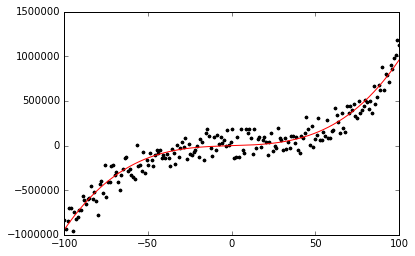

In [23]:
coefs = a, b, c, d = 1000, 10, 0, 1
n = 200
x = np.linspace(-100, 100, n)
y = a + b*x + c*x**2 + d*x**3
yo = utils.contaminate(y, 0.1, percent=True, seed=0)
plt.plot(x, yo, '.k')

reg = Regression(3)
print(reg.fit(x, yo).p_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

Calculate jacobian
[ -1.89465400e+03   5.55950824e+02   8.59755441e-01   8.94467833e-01]


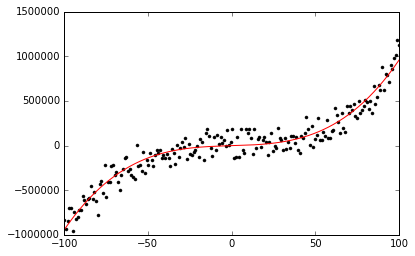

In [25]:
reg.set_optimizer(GaussNewton(initial=[0, 0, 0, 0])).fit(x, yo)

print(reg.p_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

In [26]:
reg.optimizer.stats

{'iterations': 2,
 'method': "Newton's method",
 'objective': [29856452773521.734, 2035277516521.3413, 2035277516521.3413]}